# Model Fitting to predict H1N1 Vaccination: XGBoost

#### Summary of Notebook:

This notebook *requires the xgboost library.* 

All models run in this model are XGBoost. There are two sections with gridsearches that I will convert to *markdown cells* so that they are not run when the notebook is run. The gridsearch cells are followed by cells with an XGBoost model rerun with the best parameters. 

Below is a **summary of the models run**, and their metrics: 

Optimized for | Features Used | Accuracy | Precision | Recall | Roc_Auc
--------------------|---------------|----------|-----------|--------|--------
roc_auc    |All features, target classes switched (unvacc = 1)| 0.855| 0.878 |0.948|0.730
roc_auc| All features + seasonal flu, target classes switched| 0.871|0.894|0.949|0.766 
Recall| All features, target classes switched|0.847|0.854|0.971|0.679
Recall|All features + engineered features, target classes switched|0.000|0.858|0.966|0.688|
Recall|Same as above + RandomOverSampler|0.810|0.930|0.821|0.796
Recall| Same as above but SMOTE | 0.000| 0.864| 0.955|0.701
Recall| Same as above, but gridsearched specifically with SMOTE balanced data|0.951|0.899|0.939|0.732

In [146]:
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, balanced_accuracy_score, ConfusionMatrixDisplay
from imblearn.over_sampling import RandomOverSampler, SMOTE 

### First pass Model

**Import and examine data**

In [196]:
data = pd.read_csv('../data/train_clean.csv')

In [197]:
data.head()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,no_response,no_response,0,0
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,0,1
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,0,0
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,no_response,no_response,0,1
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,0,0


In [198]:
data.dtypes

respondent_id                    int64
h1n1_concern                   float64
h1n1_knowledge                 float64
behavioral_antiviral_meds      float64
behavioral_avoidance           float64
behavioral_face_mask           float64
behavioral_wash_hands          float64
behavioral_large_gatherings    float64
behavioral_outside_home        float64
behavioral_touch_face          float64
doctor_recc_h1n1                object
doctor_recc_seasonal            object
chronic_med_condition           object
child_under_6_months           float64
health_worker                   object
health_insurance                object
opinion_h1n1_vacc_effective    float64
opinion_h1n1_risk              float64
opinion_h1n1_sick_from_vacc    float64
opinion_seas_vacc_effective    float64
opinion_seas_risk              float64
opinion_seas_sick_from_vacc    float64
age_group                       object
education                       object
race                            object
sex                      

In [199]:
# Identify categorical columns that will need to be dummified
categorical_columns = list(data.select_dtypes('object').columns)
categorical_columns

['doctor_recc_h1n1',
 'doctor_recc_seasonal',
 'chronic_med_condition',
 'health_worker',
 'health_insurance',
 'age_group',
 'education',
 'race',
 'sex',
 'income_poverty',
 'marital_status',
 'rent_or_own',
 'employment_status',
 'hhs_geo_region',
 'census_msa',
 'employment_industry',
 'employment_occupation']

**Define X and y, dummify X and train-test split**

In [200]:
X = data.drop(columns=['h1n1_vaccine', 'seasonal_vaccine'])
y = data['h1n1_vaccine']

In [201]:
Xd = pd.get_dummies(data=X, columns=categorical_columns, drop_first=True)

In [202]:
X_train, X_test, y_train, y_test = train_test_split(Xd, y, random_state=42, stratify=y)

In [203]:
X_train = np.array(X_train)
X_test = np.array(X_test)

In [204]:
y_train = np.array(y_train)
y_test = np.array(y_test)

**Run Gridsearch on XGBoost Model to find optimum parameters**  
**Please convert the following cells from markdown to code if you want to run the gridsearch**  
First-pass, optimizing for `roc_auc`,
finally, optimized for `recall`

```
xg_cls = xgb.XGBClassifier(random_state=42, 
                           use_label_encoder=False, 
                           n_jobs=-1,
                          eval_metric='error')

params = {
    'n_estimators' : [100, 200, 250],
    'max_depth' : list(range(3, 11)),
    'learning_rate' : [0.01, 0.005, 0.1, 0.3],
    'colsample_bytree' : [0.5, 0.75, 1],
    'subsample' : [0.6, 0.8, 1] 
}

gs = GridSearchCV(estimator=xg_cls, param_grid=params, scoring='roc_auc')

gs.fit(X_train, y_train)

y_pred = gs.predict(X_test)
```

```
gs.best_score_

gs.best_estimator_

gs.best_params_

accuracy_score(y_test, y_pred)

precision_score(y_test, y_pred)

recall_score(y_test, y_pred)

roc_auc_score(y_test, y_pred)

ConfusionMatrixDisplay.from_predictions(y_test, test_pred, display_labels=['Vaccinated', 'Unvaccinated'])
```

### Switch labels for vaccinated and Unvaccinated
**Scores for predicting h1n1 don't look too good with the current dataset. 
Switching labels for positive and negative class. In original dataset, vaccinated=1, unvaccinated=0. I will switch them so vaccinated=0 and unvaccinated=1 since we're more interested in the unvaccinated calss.**

**Import and examine data**

In [41]:
data = pd.read_csv('../data/train_clean.csv')

In [42]:
data['h1n1_vaccine'].value_counts()

0    21033
1     5674
Name: h1n1_vaccine, dtype: int64

In [43]:
data['seasonal_vaccine'].value_counts()

0    14272
1    12435
Name: seasonal_vaccine, dtype: int64

In [44]:
# since we're interested in the people who did not get vaccinated: switch 0 and 1 labels
data['h1n1_vaccine'].replace({1:0, 0:1}, inplace=True)
data['h1n1_vaccine'].value_counts()

1    21033
0     5674
Name: h1n1_vaccine, dtype: int64

In [45]:
data['seasonal_vaccine'].replace({1:0, 0:1}, inplace=True)
data['seasonal_vaccine'].value_counts()

1    14272
0    12435
Name: seasonal_vaccine, dtype: int64

**Define X and y, dummify X and train-test split**

In [46]:
X = data.drop(columns=['h1n1_vaccine', 'seasonal_vaccine'])
y = data['h1n1_vaccine']

In [47]:
Xd = pd.get_dummies(data=X, columns=categorical_columns, drop_first=True)

In [48]:
X_train, X_test, y_train, y_test = train_test_split(Xd, y, random_state=42, stratify=y)

In [49]:
X_train = np.array(X_train)
X_test = np.array(X_test)

In [50]:
y_train = np.array(y_train)
y_test = np.array(y_test)

In [51]:
model = xgb.XGBClassifier(random_state=42,
                          use_label_encoder=False,
                          colsample_bytree=0.5,
                          learning_rate=0.1,
                          max_depth=3,
                          n_estimators=200,
                          subsample=1
                         )
model.fit(X_train, y_train)


[20:20:18] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=16, num_parallel_tree=1,
              predictor='auto', random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [52]:
test_pred = model.predict(X_test)
train_pred = model.predict(X_train)

In [53]:
sum(y_train), len(y_train)

(15775, 20030)

In [54]:
pd.Series(y_train).value_counts()

1    15775
0     4255
dtype: int64

In [55]:
sum(y_test),len(y_test), sum(test_pred),len(test_pred)

(5258, 6677, 5676, 6677)

In [56]:
from sklearn.metrics import ConfusionMatrixDisplay

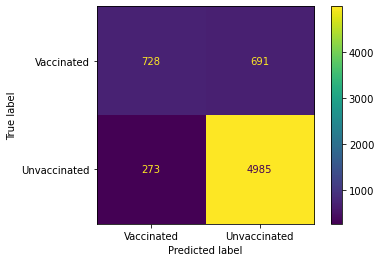

In [57]:
ConfusionMatrixDisplay.from_predictions(y_test, test_pred, display_labels=['Vaccinated', 'Unvaccinated'])

In [58]:
accuracy_score(y_test, test_pred), accuracy_score(y_train, train_pred)

(0.855623783136139, 0.8657513729405891)

In [59]:
precision_score(y_test, test_pred)

0.8782593375616632

In [60]:
recall_score(y_test, test_pred)

0.9480791175351845

In [61]:
roc_auc_score(y_test, test_pred)

0.7305582338909185

Optimized for | Features Used | Accuracy | Precision | Recall | Roc_Auc
--------------------|---------------|----------|-----------|--------|--------
roc_auc    |All features, label classes switched (unvacc = 1)| 0.855| 0.878 |0.948|0.730

### To improve model, try using seasonal vaccine as a predictor
Switch classes from original and use seasonal vaccine as a feature 

**Import and examine data**

In [62]:
data = pd.read_csv('../data/train_clean.csv')

In [63]:
data['h1n1_vaccine'].value_counts()

0    21033
1     5674
Name: h1n1_vaccine, dtype: int64

In [64]:
data['seasonal_vaccine'].value_counts()

0    14272
1    12435
Name: seasonal_vaccine, dtype: int64

In [65]:
# since we're interested in the people who did not get vaccinated: switch 0 and 1 labels
data['h1n1_vaccine'].replace({1:0, 0:1}, inplace=True)
data['h1n1_vaccine'].value_counts()

data['seasonal_vaccine'].replace({1:0, 0:1}, inplace=True)
data['seasonal_vaccine'].value_counts()

1    14272
0    12435
Name: seasonal_vaccine, dtype: int64

**Define X and y, dummify X and train-test split**

In [66]:
X = data.drop(columns=['h1n1_vaccine'])
y = data['h1n1_vaccine']

In [67]:
Xd = pd.get_dummies(data=X, columns=categorical_columns, drop_first=True)

In [68]:
X_train, X_test, y_train, y_test = train_test_split(Xd, y, random_state=42, stratify=y)

In [69]:
X_train = np.array(X_train)
X_test = np.array(X_test)

In [70]:
y_train = np.array(y_train)
y_test = np.array(y_test)

In [71]:
model = xgb.XGBClassifier(random_state=42,
                          use_label_encoder=False,
                          colsample_bytree=0.5,
                          learning_rate=0.1,
                          max_depth=3,
                          n_estimators=200,
                          subsample=1
                         )
model.fit(X_train, y_train)


[20:21:40] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=16, num_parallel_tree=1,
              predictor='auto', random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [72]:
test_pred = model.predict(X_test)
train_pred = model.predict(X_train)

In [73]:
sum(y_train), len(y_train)

(15775, 20030)

In [74]:
pd.Series(y_train).value_counts()

1    15775
0     4255
dtype: int64

In [75]:
sum(y_test),len(y_test), sum(test_pred),len(test_pred)

(5258, 6677, 5582, 6677)

In [76]:
from sklearn.metrics import ConfusionMatrixDisplay

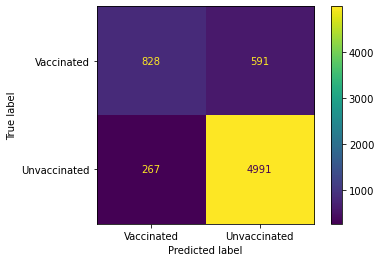

In [77]:
ConfusionMatrixDisplay.from_predictions(y_test, test_pred, display_labels=['Vaccinated', 'Unvaccinated'])

In [78]:
accuracy_score(y_test, test_pred), accuracy_score(y_train, train_pred)

(0.871499176276771, 0.8786320519221168)

In [79]:
precision_score(y_test, test_pred)

0.8941239699032605

In [80]:
recall_score(y_test, test_pred)

0.9492202358311145

In [81]:
roc_auc_score(y_test, test_pred)

0.7663648747865932

Optimized for | Features Used | Accuracy | Precision | Recall | Roc_Auc
--------------------|---------------|----------|-----------|--------|--------
roc_auc    |All features, target classes switched (unvacc = 1)| 0.855| 0.878 |0.948|0.730
roc_auc| All features + seasonal flu, target classes switched| 0.871|0.894|0.949|0.766 

### Grid search for best model, optimizing for **Recall Score**
I used the same grid search from above to optimize the hyperparameters for the models run below

#### Switch classes from original and do some feature engineering
Such as make a new feature that is 1 if the subject had both h1n1_concern and h1n1_knowledge, another one for all the behaviors and a third one for doctor recommended

**Import and examine data**

In [82]:
data = pd.read_csv('../data/train_clean.csv')

In [83]:
data.columns

Index(['respondent_id', 'h1n1_concern', 'h1n1_knowledge',
       'behavioral_antiviral_meds', 'behavioral_avoidance',
       'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'age_group',
       'education', 'race', 'sex', 'income_poverty', 'marital_status',
       'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa',
       'household_adults', 'household_children', 'employment_industry',
       'employment_occupation', 'h1n1_vaccine', 'seasonal_vaccine'],
      dtype='object')

In [84]:
data['h1n1_vaccine'].value_counts(normalize=True)

0    0.787546
1    0.212454
Name: h1n1_vaccine, dtype: float64

In [85]:
data['seasonal_vaccine'].value_counts(normalize=True)

0    0.534392
1    0.465608
Name: seasonal_vaccine, dtype: float64

In [86]:
# since we're interested in the people who did not get vaccinated: switch 0 and 1 labels
data['h1n1_vaccine'].replace({1:0, 0:1}, inplace=True)
data['h1n1_vaccine'].value_counts()

data['seasonal_vaccine'].replace({1:0, 0:1}, inplace=True)
data['seasonal_vaccine'].value_counts()

1    14272
0    12435
Name: seasonal_vaccine, dtype: int64

**Feature Engineering**

Here, I perform the following feature engineering:

Feature| Description|
-------|------------|
`doctor_recc_h1n1`| Values changed: *'no_response':0 , 0: 1, 1: 2*|
`doctor_recc_seasonal`| Values changed: *'no_response':0 , 0: 1, 1: 2*|
`chronic_med_condition`| Values changed: *'no_response':0 , 0: 1, 1: 2*|
`age_group`| Values changed *'18 - 34 Years' : 0, '35 - 44 Years' : 1, '45 - 54 Years' : 2, '55 - 64 Years' : 3, '55 - 64 Years' : 4, '65+ Years' : 5*
`health_worker`| Values changed: *'no_response':0 , 0: 1, 1: 2*|
`h1n1_all`| Interaction term : `h1n1_concern` * `h1n1_knowledge`  
`behavioral_all`| Interaction term : `behavioral_antiviral_meds` * `behavioral_avoidance` * `behavioral_face_mask` * `behavioral_wash_hands` * `behavioral_large_gatherings` * `behavioral_outside_home` * `behavioral_touch_face`
`opinion_all`| Interaction term : `opinion_h1n1_vacc_effective` * `opinion_h1n1_risk` * `opinion_h1n1_sick_from_vacc` * `opinion_seas_vacc_effective` * `opinion_seas_risk` * `opinion_seas_sick_from_vacc`
`health_worker_by_age`| Interaction term : `health_worker` * `age_group`
`doctor_recc_all` | Interaction term : `doctor_recc_h1n1` * `doctor_recc_seasonal`

In [89]:
#####
data['doctor_recc_h1n1'].value_counts()

0.0            19139
1.0             5408
no_response     2160
Name: doctor_recc_h1n1, dtype: int64

In [90]:
data['doctor_recc_h1n1'].dtypes

dtype('O')

In [91]:
data['doctor_recc_h1n1'] = data['doctor_recc_h1n1'].replace({'0.0': 1, '1.0': 2, 'no_response': 0})

data['doctor_recc_h1n1'].value_counts()

1    19139
2     5408
0     2160
Name: doctor_recc_h1n1, dtype: int64

In [92]:
#####
data['doctor_recc_seasonal'].value_counts()

0.0            16453
1.0             8094
no_response     2160
Name: doctor_recc_seasonal, dtype: int64

In [93]:
data['doctor_recc_seasonal'] = data['doctor_recc_seasonal'].replace({'0.0': 1, '1.0': 2, 'no_response': 0})
data['doctor_recc_seasonal'].value_counts()

1    16453
2     8094
0     2160
Name: doctor_recc_seasonal, dtype: int64

In [94]:
#####
data['chronic_med_condition'].value_counts()

0.0            18446
1.0             7290
no_response      971
Name: chronic_med_condition, dtype: int64

In [95]:
data['chronic_med_condition'] = data['chronic_med_condition'].replace({'no_response' : 0, '0.0' : 1, '1.0': 2})
data['chronic_med_condition'].value_counts()

1    18446
2     7290
0      971
Name: chronic_med_condition, dtype: int64

In [96]:
#####
data['age_group'].value_counts()

65+ Years        6843
55 - 64 Years    5563
45 - 54 Years    5238
18 - 34 Years    5215
35 - 44 Years    3848
Name: age_group, dtype: int64

In [97]:
data['age_group'].replace({
    '18 - 34 Years' : 0,
    '35 - 44 Years' : 1,
    '45 - 54 Years' : 2,
    '55 - 64 Years' : 3,
    '55 - 64 Years' : 4,
    '65+ Years' : 5
    
}, inplace=True)

data['age_group'].value_counts()

5    6843
4    5563
2    5238
0    5215
1    3848
Name: age_group, dtype: int64

In [98]:
#####

data['health_worker'].value_counts()

no             23004
yes             2899
no_response      804
Name: health_worker, dtype: int64

In [99]:
data['health_worker'].replace({'no_response': 0,'no': 1, 'yes': 2}, inplace=True)
data['health_worker'].value_counts()

1    23004
2     2899
0      804
Name: health_worker, dtype: int64

In [100]:
# make a new feature h1n1_all for participants who had both h1n1_concern and h1n1_knowledge
data[['h1n1_concern', 'h1n1_knowledge']].dtypes

h1n1_concern      float64
h1n1_knowledge    float64
dtype: object

In [101]:
data['h1n1_all'] = data['h1n1_concern'] * data['h1n1_knowledge']

In [102]:
# make a new feature h1n1_all for participants who responded yes to all the behavior questions
behaviour_columns = [column for column in list(data.columns) if 'behavioral' in column]
data[behaviour_columns].dtypes

behavioral_antiviral_meds      float64
behavioral_avoidance           float64
behavioral_face_mask           float64
behavioral_wash_hands          float64
behavioral_large_gatherings    float64
behavioral_outside_home        float64
behavioral_touch_face          float64
dtype: object

In [106]:
data['behavioral_all'] = 1

for column in behaviour_columns:
    data['behavioral_all'] = data['behavioral_all'] * data[column]

In [107]:
# make a new feature opinion_all for participants based on their opinion scores to the opinion questions
opinion_columns = [column for column in list(data.columns) if 'opinion' in column]
data[opinion_columns].dtypes

opinion_h1n1_vacc_effective    float64
opinion_h1n1_risk              float64
opinion_h1n1_sick_from_vacc    float64
opinion_seas_vacc_effective    float64
opinion_seas_risk              float64
opinion_seas_sick_from_vacc    float64
dtype: object

In [109]:
data['opinion_all'] = 1

for column in opinion_columns:
    data['opinion_all'] = data['opinion_all'] * data[column]

In [110]:
# doctor recommended columns
doctor_columns = [column for column in list(data.columns) if 'doctor' in column]

data['doctor_recc_all'] = 1

for column in opinion_columns:
    data['doctor_recc_all'] = data['doctor_recc_all'] * data[column]

In [113]:
# health_worker and age group

data['health_worker_by_age'] = data['health_worker'] * data['age_group']

In [114]:
data.columns

Index(['respondent_id', 'h1n1_concern', 'h1n1_knowledge',
       'behavioral_antiviral_meds', 'behavioral_avoidance',
       'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'age_group',
       'education', 'race', 'sex', 'income_poverty', 'marital_status',
       'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa',
       'household_adults', 'household_children', 'employment_industry',
       'employment_occupation', 'h1n1_vaccine', 'seasonal_vaccine', 'h1n1_all',
       'behavioral_all', 'opinion_all', 'doctor_recc_all',
       'health_worker_by_age'],
   

**Model without new features**  
I want to try running the best model without new features

In [115]:
X = data.drop(columns=['h1n1_vaccine', 'seasonal_vaccine', 'h1n1_all',
       'behavioral_all', 'opinion_all', 'doctor_recc_all',
       'health_worker_by_age'])
y = data['h1n1_vaccine']

In [116]:
categorical_columns = list(X.select_dtypes('object').columns)
categorical_columns

['health_insurance',
 'education',
 'race',
 'sex',
 'income_poverty',
 'marital_status',
 'rent_or_own',
 'employment_status',
 'hhs_geo_region',
 'census_msa',
 'employment_industry',
 'employment_occupation']

In [117]:
Xd = pd.get_dummies(data=X, columns=categorical_columns, drop_first=True)

In [118]:
X_train, X_test, y_train, y_test = train_test_split(Xd, y, random_state=42, stratify=y)

In [119]:
X_train = np.array(X_train)
X_test = np.array(X_test)

In [120]:
y_train = np.array(y_train)
y_test = np.array(y_test)

In [121]:
model = xgb.XGBClassifier(random_state=42,
                          use_label_encoder=False,
                          colsample_bytree=0.3,
                          learning_rate=0.01,
                          max_depth=8,
                          n_estimators=300,
                          subsample=1
                         )
model.fit(X_train, y_train)


[20:37:36] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=300, n_jobs=16, num_parallel_tree=1,
              predictor='auto', random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [122]:
test_pred = model.predict(X_test)
train_pred = model.predict(X_train)

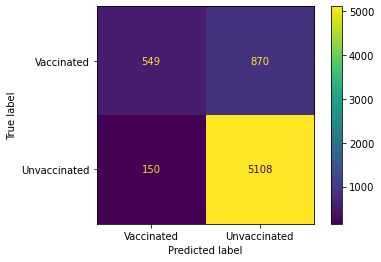

In [123]:
ConfusionMatrixDisplay.from_predictions(y_test, test_pred, display_labels=['Vaccinated', 'Unvaccinated'])

In [124]:
balanced_accuracy_score(y_test, test_pred), balanced_accuracy_score(y_train, train_pred)

(0.6791821100958009, 0.7274214543903788)

In [125]:
precision_score(y_test, test_pred)

0.8544663767146202

In [126]:
recall_score(y_test, test_pred)

0.9714720426017497

In [127]:
roc_auc_score(y_test, test_pred)

0.6791821100958009

In [128]:
accuracy_score(y_test, test_pred)

0.8472367829863712

Optimized for | Features Used | Accuracy | Precision | Recall | Roc_Auc
--------------------|---------------|----------|-----------|--------|--------
roc_auc    |All features, target classes switched (unvacc = 1)| 0.855| 0.878 |0.948|0.730
roc_auc| All features + seasonal flu, target classes switched| 0.871|0.894|0.949|0.766 
Recall| All features, target classes switched|0.847|0.854|0.971|0.679

**Model with engineered features** to see if it does better than the model without the new features

In [129]:
X = data.drop(columns=['h1n1_vaccine', 'seasonal_vaccine'])
y = data['h1n1_vaccine']

In [130]:
categorical_columns = list(X.select_dtypes('object').columns)
categorical_columns

['health_insurance',
 'education',
 'race',
 'sex',
 'income_poverty',
 'marital_status',
 'rent_or_own',
 'employment_status',
 'hhs_geo_region',
 'census_msa',
 'employment_industry',
 'employment_occupation']

In [131]:
Xd = pd.get_dummies(data=X, columns=categorical_columns, drop_first=True)

In [132]:
X_train, X_test, y_train, y_test = train_test_split(Xd, y, random_state=42, stratify=y)

In [133]:
X_train = np.array(X_train)
X_test = np.array(X_test)

In [134]:
y_train = np.array(y_train)
y_test = np.array(y_test)

In [135]:
model = xgb.XGBClassifier(random_state=42,
                          use_label_encoder=False,
                          colsample_bytree=0.3,
                          learning_rate=0.01,
                          max_depth=8,
                          n_estimators=300,
                          subsample=1
                         )
model.fit(X_train, y_train)


[20:38:06] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=300, n_jobs=16, num_parallel_tree=1,
              predictor='auto', random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [136]:
test_pred = model.predict(X_test)
train_pred = model.predict(X_train)

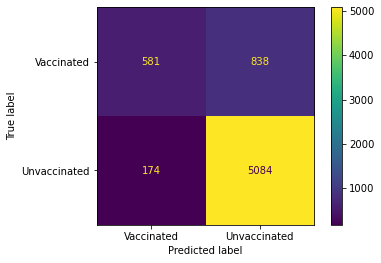

In [137]:
ConfusionMatrixDisplay.from_predictions(y_test, test_pred, display_labels=['Vaccinated', 'Unvaccinated'])

In [138]:
balanced_accuracy_score(y_test, test_pred), balanced_accuracy_score(y_train, train_pred)

(0.6881754196632079, 0.7400606352924963)

In [139]:
precision_score(y_test, test_pred)

0.8584937521107734

In [140]:
recall_score(y_test, test_pred)

0.9669075694180297

In [141]:
roc_auc_score(y_test, test_pred)

0.6881754196632079

Optimized for | Features Used | Accuracy | Precision | Recall | Roc_Auc
--------------------|---------------|----------|-----------|--------|--------
roc_auc    |All features, target classes switched (unvacc = 1)| 0.855| 0.878 |0.948|0.730
roc_auc| All features + seasonal flu, target classes switched| 0.871|0.894|0.949|0.766 
Recall| All features, target classes switched|0.847|0.854|0.971|0.679
Recall|All features + engineered features, target classes switched|0.000|0.858|0.966|0.688|

### Balance classes for H1N1 vaccine 

#### **Using random oversampler to oversample the minority class**
Note: classes are switched here

In [176]:
X = data.drop(columns=['h1n1_vaccine', 'seasonal_vaccine'])
y = data['h1n1_vaccine']

In [177]:
y.value_counts()

1    21033
0     5674
Name: h1n1_vaccine, dtype: int64

In [143]:
Xd = pd.get_dummies(data=X, columns=categorical_columns, drop_first=True)

In [144]:
X_train, X_test, y_train, y_test = train_test_split(Xd, y, random_state=42, stratify=y)

In [147]:
ros = RandomOverSampler()

X_train_over, y_train_over = ros.fit_resample(X_train, y_train)


In [148]:
X_train_over = np.array(X_train_over)
X_test = np.array(X_test)

In [149]:
y_train_over = np.array(y_train_over)
y_test = np.array(y_test)

In [150]:
model = xgb.XGBClassifier(random_state=42,
                          use_label_encoder=False,
                          colsample_bytree=0.5,
                          learning_rate=0.1,
                          max_depth=3,
                          n_estimators=200,
                          subsample=1
                         )
model.fit(X_train_over, y_train_over)


[20:42:18] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=16, num_parallel_tree=1,
              predictor='auto', random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [151]:
test_pred = model.predict(X_test)
train_pred = model.predict(X_train)

C:\ProgramData\Anaconda3\envs\xgboost\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [152]:
sum(y_train), len(y_train)

(15775, 20030)

In [153]:
pd.Series(y_train).value_counts()

1    15775
0     4255
Name: h1n1_vaccine, dtype: int64

In [154]:
sum(y_test),len(y_test), sum(test_pred),len(test_pred)

(5258, 6677, 4641, 6677)

In [155]:
from sklearn.metrics import ConfusionMatrixDisplay

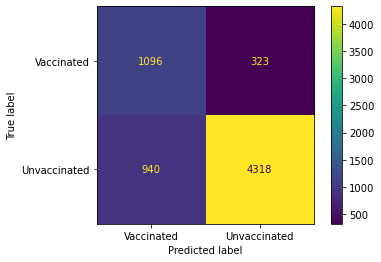

In [156]:
ConfusionMatrixDisplay.from_predictions(y_test, test_pred, display_labels=['Vaccinated', 'Unvaccinated'])

In [157]:
accuracy_score(y_test, test_pred), accuracy_score(y_train, train_pred)

(0.8108431930507713, 0.8136295556665003)

In [158]:
precision_score(y_test, test_pred)

0.9304029304029304

In [159]:
recall_score(y_test, test_pred)

0.8212248003042982

In [160]:
roc_auc_score(y_test, test_pred)

0.796799856107047

Optimized for | Features Used | Accuracy | Precision | Recall | Roc_Auc
--------------------|---------------|----------|-----------|--------|--------
roc_auc    |All features, target classes switched (unvacc = 1)| 0.855| 0.878 |0.948|0.730
roc_auc| All features + seasonal flu, target classes switched| 0.871|0.894|0.949|0.766 
Recall| All features, target classes switched|0.847|0.854|0.971|0.679
Recall|All features + engineered features, target classes switched|0.000|0.858|0.966|0.688|
Recall|Same as above + RandomOverSampler|0.810|0.930|0.821|0.796

#### **Using SMOTE to oversample minority class**
Note: classes are switched here

In [161]:
X = data.drop(columns=['h1n1_vaccine', 'seasonal_vaccine'])
y = data['h1n1_vaccine']

In [162]:
categorical_columns = list(X.select_dtypes('object').columns)
categorical_columns

['health_insurance',
 'education',
 'race',
 'sex',
 'income_poverty',
 'marital_status',
 'rent_or_own',
 'employment_status',
 'hhs_geo_region',
 'census_msa',
 'employment_industry',
 'employment_occupation']

In [163]:
Xd = pd.get_dummies(data=X, columns=categorical_columns, drop_first=True)

In [164]:
X_train, X_test, y_train, y_test = train_test_split(Xd, y, random_state=42, stratify=y)

In [165]:
from imblearn.over_sampling import SMOTE

smo = SMOTE(k_neighbors=7, random_state=42)

X_train_over, y_train_over = smo.fit_resample(X_train, y_train)


In [166]:
X_train_over = np.array(X_train_over)
X_test = np.array(X_test)

In [167]:
y_train_over = np.array(y_train_over)
y_test = np.array(y_test)

In [168]:
model = xgb.XGBClassifier(random_state=42,
                          use_label_encoder=False,
                          colsample_bytree=0.3,
                          learning_rate=0.01,
                          max_depth=8,
                          n_estimators=300,
                          subsample=1
                         )
model.fit(X_train_over, y_train_over)


[20:42:33] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=300, n_jobs=16, num_parallel_tree=1,
              predictor='auto', random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [169]:
test_pred = model.predict(X_test)
train_pred = model.predict(X_train)

C:\ProgramData\Anaconda3\envs\xgboost\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


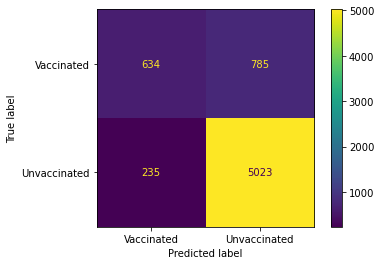

In [170]:
ConfusionMatrixDisplay.from_predictions(y_test, test_pred, display_labels=['Vaccinated', 'Unvaccinated'])

In [171]:
balanced_accuracy_score(y_test, test_pred), balanced_accuracy_score(y_train, train_pred)

(0.7010498583185165, 0.7374895201133747)

In [172]:
precision_score(y_test, test_pred)

0.8648415977961432

In [173]:
recall_score(y_test, test_pred)

0.9553062000760746

In [174]:
roc_auc_score(y_test, test_pred)

0.7010498583185165

Optimized for | Features Used | Accuracy | Precision | Recall | Roc_Auc
--------------------|---------------|----------|-----------|--------|--------
roc_auc    |All features, target classes switched (unvacc = 1)| 0.855| 0.878 |0.948|0.730
roc_auc| All features + seasonal flu, target classes switched| 0.871|0.894|0.949|0.766 
Recall| All features, target classes switched|0.847|0.854|0.971|0.679
Recall|All features + engineered features, target classes switched|0.000|0.858|0.966|0.688|
Recall|Same as above + RandomOverSampler|0.810|0.930|0.821|0.796
Recall| Same as above + SMOTE | 0.000| 0.864| 0.955|0.701

**Grid Search for SMOTE** : I tried this, optimizing for both `roc_auc_score` and `recall` and while the grid search parameters were slightly different, the metrics were very similar as shown below, so I selected the best parameters fromm the gridsearch optimizing for roc_auc as the final model.

|Parameter|Optimizing for roc_auc|Optimizing for recall|
|---------|----------------------|---------------------|
booster|gbtree|gbtree|
colsample_bytree|0.9|0.9|
learning_rate|0.05|0.05|
max_depth|7|3|
n_estimators|100|600|
subsample|0.5|1|

|Metric|Optimizing for roc_auc|Optimizing for recall|
|------|----------------------|---------------------| 
|accuracy|0.852|0.852|
|precision|0.879|0.879|
|roc_auc|0.730|0.732
|recall|0.942|0.939|
|balanced_accuracy|0.730|0.732




**Please convert the following cells from markdown to code if you want to run this gridsearch**

```
xg_cls = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='error')

params = {
    'tree_method' :['auto', 'hist'],
    'booster' : ['gbtree'],
    'n_estimators' : [100, 600],
    'max_depth' : [3, 7],
    'learning_rate' : [0.001,0.05],
    'colsample_bytree' : [0.7, 0.9],
    'subsample' : [0.5, 1] 
}

gs = GridSearchCV(estimator=xg_cls, param_grid=params, scoring='recall')

gs.fit(X_train_over, y_train_over)

y_pred = gs.predict(X_test)

```

--------------------
```
gs.best_score_ 

# result 0.9463708399366085

```
------------------------

```
gs.best_estimator_

#result

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9,
              enable_categorical=False, eval_metric='error', gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=600, n_jobs=16, num_parallel_tree=1,
              predictor='auto', random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='auto',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

```

----------------------------------
```
gs.best_params_

# result

{'booster': 'gbtree',
 'colsample_bytree': 0.9,
 'learning_rate': 0.05,
 'max_depth': 3,
 'n_estimators': 600,
 'subsample': 1,
 'tree_method': 'auto'}
```
--------------------------------------

```
test_pred = gs.predict(X_test)
train_pred = gs.predict(X_train)

ConfusionMatrixDisplay.from_predictions(y_test, test_pred, display_labels=['Vaccinated', 'Unvaccinated'])

accuracy_score(y_test, test_pred), accuracy_score(y_train, train_pred)

precision_score(y_test, test_pred)

recall_score(y_test, test_pred)

roc_auc_score(y_test, test_pred)

balanced_accuracy_score(y_test, test_pred)

X.columns

```

### Final Model for feature importance selection
This model has classes switched so that vaccinated = 0, unvaccinated = 1, 
and, uses SMOTE class balanced data, as well as the new engineered features

I used the `feature_importances_` property to determine which features were most important for predicting the target label. The results are tabulated below: 

|feature|importance
|-------|----------
|doctor_recc_h1n1|0.2413746
|health_insurance_yes|0.11566545
|opinion_h1n1_vacc_effective|0.05127814
|opinion_h1n1_risk|0.026844215
|health_insurance_no_response|0.025501551
|health_worker|0.017758252
|education_College Graduate|0.016372165
|opinion_seas_risk|0.015200119
|doctor_recc_seasonal|0.014214159
|h1n1_knowledge|0.013103445
|education_no_response|0.013036097
|opinion_seas_vacc_effective|0.0128032435
|employment_industry_fcxhlnwr|0.012155328
|sex_Male|0.011713602
|employment_occupation_dcjcmpih|0.011503535

In [178]:
xgb_best = xgb.XGBClassifier(random_state=42,
                             use_label_encoder=False,
                             eval_metric='error',
                            booster='gbtree',
                            colsample_bytree=0.9,
                            learning_rate=0.05,
                            max_depth=3,
                            n_estimators=600,
                            subsample=1)
xgb_best.fit(X_train_over, y_train_over)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9,
              enable_categorical=False, eval_metric='error', gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=600, n_jobs=16, num_parallel_tree=1,
              predictor='auto', random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [179]:
test_pred = xgb_best.predict(X_test)
train_pred = xgb_best.predict(X_train)

C:\ProgramData\Anaconda3\envs\xgboost\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


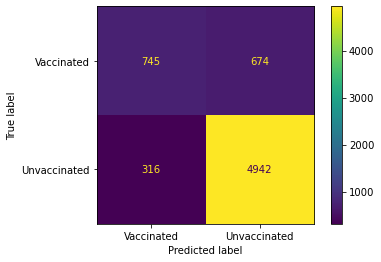

In [180]:
ConfusionMatrixDisplay.from_predictions(y_test, test_pred, display_labels=['Vaccinated', 'Unvaccinated'])

In [181]:
accuracy_score(y_test, test_pred), accuracy_score(y_train, train_pred)

(0.8517298187808896, 0.8667998002995507)

In [182]:
precision_score(y_test, test_pred)

0.8799857549857549

In [183]:
recall_score(y_test, test_pred)

0.9399011030810194

In [184]:
roc_auc_score(y_test, test_pred)

0.7324593605609466

In [185]:
balanced_accuracy_score(y_test, test_pred)

0.7324593605609466

This code will save the best features in the data folder
```
pd.DataFrame({'feature': Xd.columns, 'importance':xgb_best.feature_importances_}).sort_values('importance', ascending=False).head(15).to_csv('../data/XGB_H1N1_feature_imp.csv', index=False)
```

In [187]:
top_features = pd.DataFrame({'feature': Xd.columns, 'importance':xgb_best.feature_importances_}).sort_values('importance', ascending=False).head(20)

In [188]:
top_features

,feature,importance
15,opinion_h1n1_vacc_effective,0.114573
29,health_insurance_no_response,0.107744
16,opinion_h1n1_risk,0.083394
2,h1n1_knowledge,0.069584
7,behavioral_large_gatherings,0.052834
42,marital_status_Not Married,0.051751
44,rent_or_own_Rent,0.039768
9,behavioral_touch_face,0.035462
19,opinion_seas_risk,0.032780
18,opinion_seas_vacc_effective,0.027051


In [189]:
import matplotlib.pyplot as plt

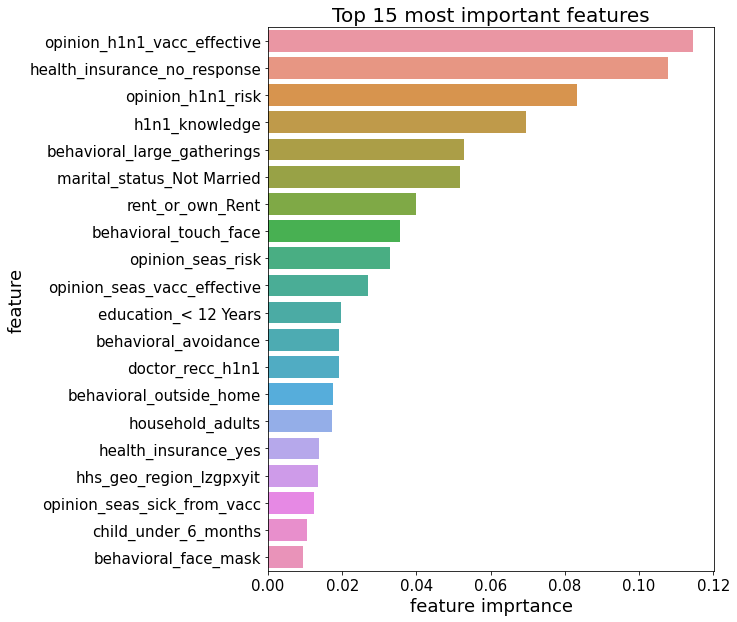

In [195]:
plt.figure(figsize=(8,10))
sns.barplot(data=top_features, y='feature', x='importance')
plt.title("Top 15 most important features", size=20)
plt.xlabel('feature imprtance', size=18)
plt.ylabel('feature', size=18)
plt.xticks(size=15)
plt.yticks(size=15);

### Summary

Optimized for | Features Used | Accuracy | Precision | Recall | Roc_Auc
--------------------|---------------|----------|-----------|--------|--------
roc_auc    |All features, target classes switched (unvacc = 1)| 0.855| 0.878 |0.948|0.730
roc_auc| All features + seasonal flu, target classes switched| 0.871|0.894|0.949|0.766 
Recall| All features, target classes switched|0.847|0.854|0.971|0.679
Recall|All features + engineered features, target classes switched|0.000|0.858|0.966|0.688|
Recall|Same as above + RandomOverSampler|0.810|0.930|0.821|0.796
Recall| Same as above but SMOTE | 0.000| 0.864| 0.955|0.701
Recall| Same as above, but gridsearched specifically with SMOTE balanced data|0.951|0.899|0.939|0.732